In [1]:
using Makie

ArgumentError: ArgumentError: Package Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.


In [2]:
gui(scene) = display(Makie.AbstractPlotting.PlotDisplay(), scene)

gui (generic function with 1 method)

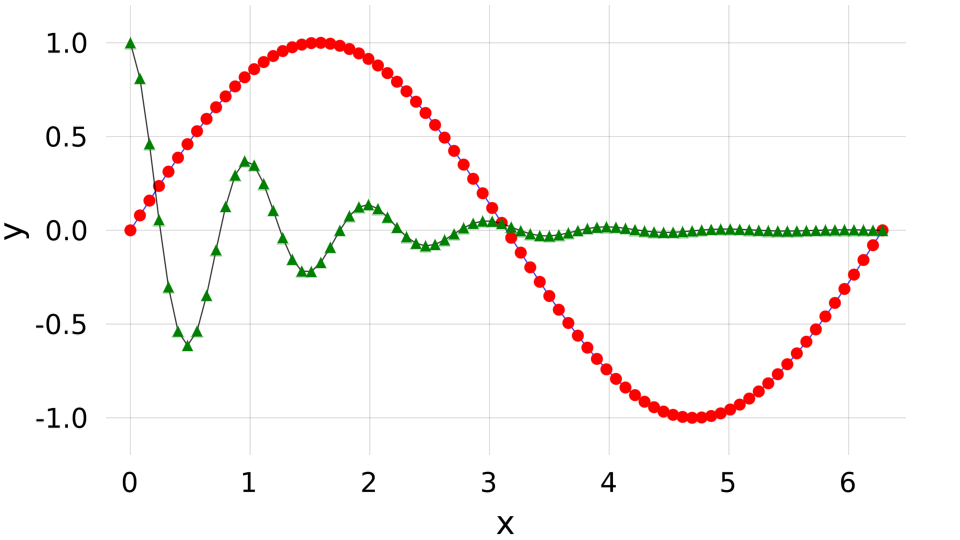

In [41]:
 x = range(0, stop = 2pi, length = 80)
 f1(x) = sin.(x)
 f2(x) = exp.(-x) .* cos.(2pi*x)
 y1 = f1(x)
 y2 = f2(x)

 scene = lines(x, y1, color = :blue)
 scatter!(scene, x, y1, color = :red, markersize = 0.1)

 lines!(scene, x, y2, color = :black)
 scatter!(scene, x, y2, color = :green, marker = :utriangle, markersize = 0.1)

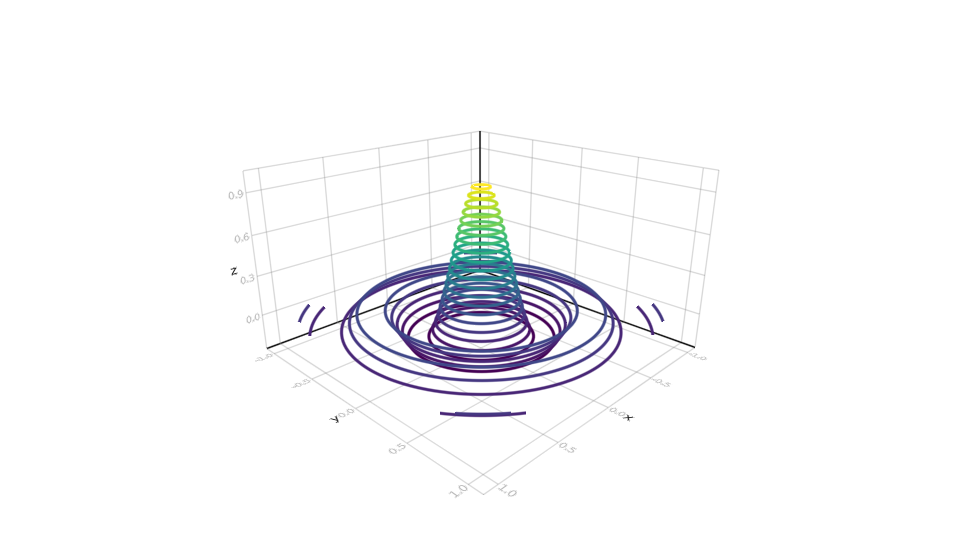

In [43]:
 function xy_data(x, y)
     r = sqrt(x*x + y*y)
     r == 0.0 ? 1f0 : (sin(r)/r)
 end
 r = range(-1, stop = 1, length = 100)
 contour3d(r, r, (x,y)-> xy_data(10x, 10y), levels = 20, linewidth = 3)

In [46]:
 N = 51
 x = range(-2, stop = 2, length = N)
 y = x
 z = (-x .* exp.(-x .^ 2 .- (y') .^ 2)) .* 4
 scene = surface(x, y, z)
 xm, ym, zm = minimum(scene.limits[])
 contour!(scene, x, y, z, levels = 15, linewidth = 2, transformation = (:xy, zm))
 wireframe!(scene, x, y, z, overdraw = true, transparency = true, color = (:black, 0.1))
 scene
gui(scene)


GLMakie.Screen(...)

In [49]:
 using LinearAlgebra

 n = 20
 g   = (x,y,z) -> x*exp(cos(y)*z)
 ∇g  = (x,y,z) -> Point3f0(exp(cos(y)*z), -sin(y)*z*x*exp(cos(y)*z), x*cos(y)*exp(cos(y)*z))
 ∇ˢg = (x,y,z) -> ∇g(x,y,z) - Point3f0(x,y,z)*dot(Point3f0(x,y,z), ∇g(x,y,z))

 θ = [0;(0.5:n-0.5)/n;1]
 φ = [(0:2n-2)*2/(2n-1);2]
 x = [cospi(φ)*sinpi(θ) for θ in θ, φ in φ]
 y = [sinpi(φ)*sinpi(θ) for θ in θ, φ in φ]
 z = [cospi(θ) for θ in θ, φ in φ]

 pts = vec(Point3f0.(x, y, z))
 ∇ˢg = vec(∇ˢg.(x, y, z)) .* 0.1f0

 x = surface(x, y, z)
 arrows!(
     pts, ∇ˢg,
    
     arrowsize = 0.03, linecolor = (:white, 0.6), linewidth = 3
 )
# gui(x)

GLMakie.Screen(...)

# Animated

### Rotating Graph

In [50]:
# using AbstractPlotting

 scene = Scene()
 f(t, v, s) = (sin(v + t) * s, cos(v + t) * s)
 time_node = Node(0.0)
 p1 = scatter!(scene, lift(t-> f.(t, range(0, stop = 2pi, length = 50), 1), time_node))[end]
 p2 = scatter!(scene, lift(t-> f.(t * 2.0, range(0, stop = 2pi, length = 50), 1.5), time_node))[end]
 points = lift(p1[1], p2[1]) do pos1, pos2
     map((a, b)-> (a, b), pos1, pos2)
 end
 linesegments!(scene, points)
 N = 150
 record(scene, "output.mp4", range(0, stop = 10, length = N)) do i
     push!(time_node, i)
end

"output.mp4"

### Electrostatic Repulsion

In [51]:
 using LinearAlgebra


 clip11(x) = max(-1.0, min(1.0, x))

 function repel(particles_node, N)
     particles = particles_node[]
     @inbounds for i in 1:N
         ftot = Vec3f0(0)
         p1 = particles[i]
         for j in 1:N
             if i != j
                 p2 = particles[j]
                 Δσ = acos(clip11(dot(p1, p2))) # great circle distance
                 ftot += (p1 - p2)/max(1e-3, Δσ^2)
             end
         end
         particles[i] = normalize(p1 + 0.001 * ftot)
     end
     particles_node[] = particles
 end

 function addparticle!(particles, colors, nparticles)
     nparticles[] = nparticles[] + 1
     particles[][nparticles[]] = normalize(randn(Point3f0))
     colors[][nparticles[]] = to_color(:green)
     particles[] = particles[]
     colors[] = colors[]
 end

 s = Scene(show_axis = false)
 mesh!(s, Sphere(Point3f0(0), 1f0), color = :gray)

 max_particles = 5000
 # Sadly, you currently can't resize 3D mesh particles, so we need to
 # implement resize on our own...
 particles = Node(fill(Point3f0(NaN), max_particles))
 colors = Node(fill(RGBAf0(0, 0, 0, 0), max_particles))
 meshscatter!(s, particles, color = colors, markersize = 0.05)
 nparticles = Node(0)
 for i=1:10
     addparticle!(particles, colors, nparticles)
 end
 update_cam!(s, FRect3D(Vec3f0(0), Vec3f0(1)))
 s.center = false # don't reset the camera by display
 N = 1000 # N gets replaced by 100 for testing
 record(s, "output.mp4", 1:N) do iter
     isodd(iter) && addparticle!(particles, colors, nparticles)
     repel(particles, nparticles[])
end

ErrorException: Screen not open!

### Lattice Vibrations

In [52]:
# using Makie.AbstractPlotting
import Makie.AbstractPlotting: Plot, default_theme, plot!, to_value


 struct Simulation
     grid::Vector{Point3f0}
 end
 # Probably worth having a macro for this!
 function Makie.AbstractPlotting.default_theme(scene::SceneLike, ::Type{<: Plot(Simulation)})
     Theme(
         advance = 0,
         molecule_sizes = [0.08, 0.04, 0.04],
         molecule_colors = [:maroon, :deepskyblue2, :deepskyblue2]
     )
 end

 # The recipe! - will get called for plot(!)(x::SimulationResult)
 function AbstractPlotting.plot!(p::Plot(Simulation))
     sim = to_value(p[1]) # first argument is the SimulationResult
     # when advance changes, get new positions from the simulation
     mpos = lift(p[:advance]) do i
         sim.grid .+ rand(Point3f0, length(sim.grid)) .* 0.01f0
     end
     # size shouldn't change, so we might as well get the value instead of signal
     pos = to_value(mpos)
     N = length(pos)
     sizes = lift(p[:molecule_sizes]) do s
         repeat(s, outer = N ÷ 3)
     end
     sizes = lift(p[:molecule_sizes]) do s
         repeat(s, outer = N ÷ 3)
     end
     colors = lift(p[:molecule_colors]) do c
         repeat(c, outer = N ÷ 3)
     end
     scene = meshscatter!(p, mpos, markersize = sizes, color = colors)
     indices = Int[]
     for i in 1:3:N
         push!(indices, i, i + 1, i, i + 2)
     end
     meshplot = p.plots[end] # meshplot is the last plot we added to p
     # meshplot[1] -> the positions (first argument) converted to points, so
     # we don't do the conversion 2 times for linesegments!
     linesegments!(p, lift(x-> view(x, indices), meshplot[1]))
 end

 # To write out a video of the whole simulation
 n = 5
 r = range(-1, stop = 1, length = n)
 mygrid = Point3f0.(r, reshape(r, (1, n, 1)), reshape(r, (1, 1, n)))
 molecules = map(1:(n^3) * 3) do i
     i3 = ((i - 1) ÷ 3) + 1
     xy = 0.1; z = 0.08
     i % 3 == 1 && return mygrid[i3]
     i % 3 == 2 && return mygrid[i3] + Point3f0(xy, xy, z)
     i % 3 == 0 && return mygrid[i3] + Point3f0(-xy, xy, z)
 end
 result = Simulation(molecules)
 scene = plot(result)
 N = 100
 record(scene, "output.mp4", 1:N) do i
     scene[end][:advance] = i
end

"output.mp4"

### Moire

In [53]:
 function cartesian(ll)
     return Point3f0(
         cos(ll[1]) * sin(ll[2]),
         sin(ll[1]) * sin(ll[2]),
         cos(ll[2])
     )
 end
 fract(x) = x - floor(x)
 function calcpositions(rings, index, time, audio)
     movement, radius, speed, spin = 1, 2, 3, 4;
     position = Point3f0(0.0)
     precision = 0.2f0
     for ring in rings
         position += ring[radius] * cartesian(
             precision *
             index *
             Point2f0(ring[spin] + Point2f0(sin(time * ring[speed]), cos(time * ring[speed])) * ring[movement])
         )
     end
     amplitude = audio[round(Int, clamp(fract(position[1] * 0.1), 0, 1) * (25000-1)) + 1]; # index * 0.002
     position *= 1.0 + amplitude * 0.5;
     position
 end
 rings = [(0.1f0, 1.0f0, 0.00001f0, Point2f0(0.2, 0.1)), (0.1f0, 0.0f0, 0.0002f0, Point2f0(0.052, 0.05))]
 N2 = 25000
 t_audio = sin.(range(0, stop = 10pi, length = N2)) .+ (cos.(range(-3, stop = 7pi, length = N2)) .* 0.6) .+ (rand(Float32, N2) .* 0.1) ./ 2f0
 start = time()
 t = (time() - start) * 100
 pos = calcpositions.((rings,), 1:N2, t, (t_audio,))

 scene = lines(
     pos, color = RGBAf0.(to_colormap(:RdBu, N2), 0.6),
     thickness = 0.6f0, show_axis = false, transparency = true
 )
 linesegments!(
     scene, FRect3D(Vec3f0(-1.5), Vec3f0(3)), raw = true,
     linewidth = 3, linestyle = :dot
 )
 eyepos = Vec3f0(5, 1.5, 0.5)
 lookat = Vec3f0(0)
 update_cam!(scene, eyepos, lookat)
 scene.center = false # prevent scene from recentering on display
 l = scene[1]
 N = 150
 record(scene, "output.mp4", 1:N) do i
     t = (time() - start) * 700
     pos .= calcpositions.((rings,), 1:N2, t, (t_audio,))
     l[1] = pos # update argument 1
     rotate_cam!(scene, 0.0, 0.01, 0.01)
end


ErrorException: Screen not open!

Animating a surface: https://vimeo.com/237284958

# Slider

In [13]:
using Makie
using Makie.AbstractPlotting
using Colors

x₀ =-5.
#gateState = false
xRange =  10

#  deflection
p₀(x) = x/2

# plot
nPts = 100.
x = (x₀ .+ collect((-nPts/2.):(nPts/2.))/nPts*xRange)
scene = lines(x,  p₀(x),
             linewidth =4,
             color = :darkcyan,
             leg = false
        )
axis = scene[Axis]
axis[:names][:axisnames] =  ( "x","y")

D = Node(x₀)
HC_handle = scatter!(lift(x->[x],  D), [2], marker=:circle,
          markersize = 1., color = :red)[end]

s1 = slider(LinRange(-10.0, 0.0, 101),
      raw = true, camera = campixel!, start = -10.0)
kx = s1[end][:value]

scatter!(scene, lift(x->[x; x],kx), lift(x-> [0.5; p₀(x)], kx),
    marker = :hexagon,  color = RGBA(.5,0.,.5,.5),
    markersize = .35, strokewidth = 1, strokecolor = :black)

S = hbox(scene, s1, parent = Scene(resolution = (800, 600)))
display(S) 

@async while isopen(S)
  p = p₀((10.0+kx[])/10.)
  gateState = rand(1)[]<p
  HC_handle[:color] = gateState ? :gold1 : :dodgerblue1
#   push!(D, -3. + rand(1)[]/5.)
  yield()
end

RecordEvents(S, "output");